# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch import tensor
from torch import optim
from torchvision import datasets,transforms
import PIL
from collections import OrderedDict
import argparse
from PIL import Image
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import json
%matplotlib inline



## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train':transforms.Compose([transforms.RandomResizedCrop(size=224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                               ]),
     'valid':transforms.Compose([transforms.Resize(size=256),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                               ]),
    'test':transforms.Compose([transforms.Resize(size=256),
                                transforms.CenterCrop(size=224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                               ]),
                   } 
# TODO: Load the datasets with ImageFolder
image_datasets = {'train': datasets.ImageFolder(train_dir,transform = data_transforms['train']),
                  'valid': datasets.ImageFolder(valid_dir,transform = data_transforms['valid']),
                  'test': datasets.ImageFolder(test_dir,transform = data_transforms['test']),
                 }
# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(image_datasets['train'],batch_size = 64,shuffle=True)
validation_loader = torch.utils.data.DataLoader(image_datasets['valid'],batch_size = 64,shuffle=True)
test_loader = torch.utils.data.DataLoader(image_datasets['test'],batch_size = 64,shuffle=True)

train_loader_size=len(train_loader)
validation_loader_size=len(validation_loader)
test_loader_size=len(test_loader)
train_loader_size,validation_loader_size,test_loader_size

(103, 13, 13)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:

# TODO: Build and train your network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)

#turn off gradient for our model
for param in model.parameters():
    param.requires_grad=False
    
from collections import OrderedDict

# define our new classifier
classifier=nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(25088,1024)),
    ('relu1',nn.ReLU()),
    ('dropout1',nn.Dropout(p=0.5)),
    ('fc2',nn.Linear(1024,512)),
    ('relu2',nn.ReLU()),
    ('dropout2',nn.Dropout(p=0.5)),
    ('fc4',nn.Linear(512,102)),
    ('output',nn.LogSoftmax(dim=1))
]))
model.classifier=classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.003)
model.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 99195288.61it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
epochs=4


for epoch in range (epochs):
    print("Epoch: {}/{}".format(epoch+1,epochs))
    model.train()
    running_loss=0.0
    
        
    for i, (images,labels) in enumerate(train_loader):
        images,labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
            
        logps=model(images)
        loss=criterion(logps,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0) 
        print(" Train Loss: {:.4f}".format(loss.item()))
        
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()
                
                
            for ii,(images,labels) in enumerate(validation_loader):
                optimizer.zero_grad()
                images,labels = images.to(device),labels.to(device)
                logps = model.forward(images)
                loss = criterion(logps,labels)
                valid_loss += loss.item() * images.size(0)
                
                ret,predictions = torch.max(logps.data,1)
                equality=predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(equality.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
               
                print(" validation Loss:{:.4f}".format(loss.item()),
                    " accuracy: {:.4f}".format(acc.item()))
        
        



Epoch: 1/4
 Train Loss: 4.6157
 validation Loss:9.6134  accuracy: 0.0156
 validation Loss:10.0502  accuracy: 0.0000
 validation Loss:9.7240  accuracy: 0.0469
 validation Loss:9.4197  accuracy: 0.0156
 validation Loss:8.7720  accuracy: 0.0625
 validation Loss:8.5472  accuracy: 0.0469
 validation Loss:10.0108  accuracy: 0.0000
 validation Loss:8.7957  accuracy: 0.0625
 validation Loss:9.5998  accuracy: 0.0312
 validation Loss:9.1639  accuracy: 0.0625
 validation Loss:9.4209  accuracy: 0.0156
 validation Loss:9.7488  accuracy: 0.0156
 validation Loss:9.6620  accuracy: 0.0600
 Train Loss: 8.9245
 validation Loss:18.0130  accuracy: 0.0000
 validation Loss:15.9477  accuracy: 0.0000
 validation Loss:15.0578  accuracy: 0.0312
 validation Loss:16.1541  accuracy: 0.0000
 validation Loss:15.3676  accuracy: 0.0000
 validation Loss:15.6457  accuracy: 0.0156
 validation Loss:17.4560  accuracy: 0.0156
 validation Loss:14.2469  accuracy: 0.0156
 validation Loss:13.8423  accuracy: 0.0156
 validation Lo

 validation Loss:4.1868  accuracy: 0.0625
 validation Loss:4.0853  accuracy: 0.1719
 validation Loss:4.0542  accuracy: 0.0781
 validation Loss:4.0561  accuracy: 0.1875
 validation Loss:4.0493  accuracy: 0.0625
 validation Loss:4.2701  accuracy: 0.0938
 validation Loss:3.9218  accuracy: 0.0800
 Train Loss: 4.3829
 validation Loss:4.1107  accuracy: 0.1406
 validation Loss:4.1765  accuracy: 0.1094
 validation Loss:4.1988  accuracy: 0.1250
 validation Loss:4.3338  accuracy: 0.0781
 validation Loss:3.8834  accuracy: 0.1562
 validation Loss:3.8923  accuracy: 0.1406
 validation Loss:3.7853  accuracy: 0.2188
 validation Loss:4.2670  accuracy: 0.0625
 validation Loss:3.8552  accuracy: 0.1875
 validation Loss:3.9766  accuracy: 0.0938
 validation Loss:4.2404  accuracy: 0.0781
 validation Loss:3.9920  accuracy: 0.1094
 validation Loss:4.1737  accuracy: 0.1200
 Train Loss: 4.1394
 validation Loss:4.0525  accuracy: 0.0781
 validation Loss:3.8276  accuracy: 0.2031
 validation Loss:4.0762  accuracy: 0

 Train Loss: 3.3558
 validation Loss:3.0957  accuracy: 0.2656
 validation Loss:2.8701  accuracy: 0.3906
 validation Loss:3.0656  accuracy: 0.2969
 validation Loss:2.6605  accuracy: 0.3281
 validation Loss:3.2162  accuracy: 0.1875
 validation Loss:2.6306  accuracy: 0.2812
 validation Loss:3.1422  accuracy: 0.2656
 validation Loss:3.1296  accuracy: 0.2344
 validation Loss:2.9910  accuracy: 0.2344
 validation Loss:3.4650  accuracy: 0.2656
 validation Loss:2.8731  accuracy: 0.3438
 validation Loss:3.1405  accuracy: 0.2812
 validation Loss:3.2494  accuracy: 0.2000
 Train Loss: 3.4720
 validation Loss:3.2087  accuracy: 0.2188
 validation Loss:3.0870  accuracy: 0.2344
 validation Loss:2.8324  accuracy: 0.3438
 validation Loss:3.0271  accuracy: 0.3281
 validation Loss:2.6132  accuracy: 0.4375
 validation Loss:2.8257  accuracy: 0.3125
 validation Loss:2.7598  accuracy: 0.3438
 validation Loss:3.3531  accuracy: 0.1875
 validation Loss:3.1996  accuracy: 0.2812
 validation Loss:3.2430  accuracy: 0

 validation Loss:2.2267  accuracy: 0.4531
 validation Loss:2.0228  accuracy: 0.5312
 validation Loss:2.2191  accuracy: 0.4531
 validation Loss:2.2888  accuracy: 0.4688
 validation Loss:2.1748  accuracy: 0.4688
 validation Loss:2.5853  accuracy: 0.3438
 validation Loss:2.2998  accuracy: 0.4200
 Train Loss: 1.9501
 validation Loss:2.2572  accuracy: 0.5000
 validation Loss:1.9586  accuracy: 0.5625
 validation Loss:2.2370  accuracy: 0.4844
 validation Loss:2.6234  accuracy: 0.4062
 validation Loss:2.3050  accuracy: 0.4531
 validation Loss:2.4764  accuracy: 0.3281
 validation Loss:2.0654  accuracy: 0.5000
 validation Loss:2.3174  accuracy: 0.4375
 validation Loss:2.4076  accuracy: 0.2969
 validation Loss:1.9474  accuracy: 0.4531
 validation Loss:2.0833  accuracy: 0.4531
 validation Loss:1.8546  accuracy: 0.5312
 validation Loss:2.0597  accuracy: 0.5000
 Train Loss: 2.1588
 validation Loss:2.2731  accuracy: 0.4688
 validation Loss:2.3320  accuracy: 0.4219
 validation Loss:1.8916  accuracy: 0

 Train Loss: 2.5685
 validation Loss:1.9142  accuracy: 0.4688
 validation Loss:1.7811  accuracy: 0.5312
 validation Loss:1.7169  accuracy: 0.5938
 validation Loss:2.0813  accuracy: 0.4375
 validation Loss:2.0338  accuracy: 0.4219
 validation Loss:1.8462  accuracy: 0.4688
 validation Loss:1.7812  accuracy: 0.5469
 validation Loss:1.9315  accuracy: 0.4688
 validation Loss:1.6785  accuracy: 0.4844
 validation Loss:2.0893  accuracy: 0.4219
 validation Loss:1.6617  accuracy: 0.5000
 validation Loss:1.7090  accuracy: 0.5312
 validation Loss:2.0917  accuracy: 0.4000
 Train Loss: 2.4949
 validation Loss:1.5935  accuracy: 0.5938
 validation Loss:1.5282  accuracy: 0.5938
 validation Loss:1.6846  accuracy: 0.5156
 validation Loss:1.7262  accuracy: 0.4844
 validation Loss:2.3197  accuracy: 0.3750
 validation Loss:1.9112  accuracy: 0.4531
 validation Loss:1.9385  accuracy: 0.4219
 validation Loss:1.7640  accuracy: 0.5625
 validation Loss:1.8411  accuracy: 0.4688
 validation Loss:1.9769  accuracy: 0

 validation Loss:1.9427  accuracy: 0.5156
 validation Loss:1.3114  accuracy: 0.6406
 validation Loss:1.2777  accuracy: 0.6094
 validation Loss:1.1570  accuracy: 0.6719
 validation Loss:1.7679  accuracy: 0.5781
 validation Loss:1.7021  accuracy: 0.5312
 validation Loss:1.5683  accuracy: 0.5400
 Train Loss: 1.8064
 validation Loss:1.2128  accuracy: 0.7031
 validation Loss:1.6577  accuracy: 0.6094
 validation Loss:1.8190  accuracy: 0.5469
 validation Loss:1.4680  accuracy: 0.5938
 validation Loss:1.6278  accuracy: 0.5469
 validation Loss:1.5017  accuracy: 0.6250
 validation Loss:1.8167  accuracy: 0.5938
 validation Loss:1.3826  accuracy: 0.6562
 validation Loss:1.4883  accuracy: 0.5781
 validation Loss:1.3893  accuracy: 0.6250
 validation Loss:1.3961  accuracy: 0.5469
 validation Loss:1.3989  accuracy: 0.5781
 validation Loss:1.4608  accuracy: 0.6200
 Train Loss: 1.7628
 validation Loss:1.8420  accuracy: 0.5312
 validation Loss:1.4417  accuracy: 0.6250
 validation Loss:1.5684  accuracy: 0

 Train Loss: 1.9450
 validation Loss:1.1037  accuracy: 0.6875
 validation Loss:1.3339  accuracy: 0.6562
 validation Loss:1.6150  accuracy: 0.5781
 validation Loss:1.3553  accuracy: 0.6562
 validation Loss:1.6423  accuracy: 0.5469
 validation Loss:1.5002  accuracy: 0.5469
 validation Loss:1.1955  accuracy: 0.6094
 validation Loss:1.7669  accuracy: 0.5312
 validation Loss:1.3057  accuracy: 0.5938
 validation Loss:1.1643  accuracy: 0.6562
 validation Loss:1.1680  accuracy: 0.6562
 validation Loss:1.1937  accuracy: 0.6250
 validation Loss:1.5600  accuracy: 0.5200
 Train Loss: 1.4816
 validation Loss:1.0728  accuracy: 0.7344
 validation Loss:1.4022  accuracy: 0.5781
 validation Loss:1.4134  accuracy: 0.5625
 validation Loss:1.1631  accuracy: 0.7031
 validation Loss:1.1323  accuracy: 0.6719
 validation Loss:1.3776  accuracy: 0.5000
 validation Loss:2.3786  accuracy: 0.5156
 validation Loss:1.3866  accuracy: 0.5625
 validation Loss:1.2584  accuracy: 0.6719
 validation Loss:1.1936  accuracy: 0

 validation Loss:1.1953  accuracy: 0.6719
 validation Loss:1.1659  accuracy: 0.7031
 validation Loss:0.9437  accuracy: 0.7031
 validation Loss:1.1480  accuracy: 0.6250
 validation Loss:1.3446  accuracy: 0.6875
 validation Loss:1.3430  accuracy: 0.5469
 validation Loss:1.8331  accuracy: 0.4800
 Train Loss: 1.5587
 validation Loss:1.0126  accuracy: 0.7188
 validation Loss:1.1732  accuracy: 0.6562
 validation Loss:1.1818  accuracy: 0.6250
 validation Loss:1.3767  accuracy: 0.5938
 validation Loss:1.3440  accuracy: 0.5625
 validation Loss:1.3355  accuracy: 0.6719
 validation Loss:1.2646  accuracy: 0.6094
 validation Loss:1.7067  accuracy: 0.6562
 validation Loss:1.2849  accuracy: 0.7188
 validation Loss:1.2396  accuracy: 0.6406
 validation Loss:1.4887  accuracy: 0.6250
 validation Loss:1.2650  accuracy: 0.6094
 validation Loss:1.2355  accuracy: 0.6800
Epoch: 2/4
 Train Loss: 3.9461
 validation Loss:1.5281  accuracy: 0.5625
 validation Loss:1.5181  accuracy: 0.5000
 validation Loss:1.0987  

 Train Loss: 1.3390
 validation Loss:1.4484  accuracy: 0.6406
 validation Loss:1.0452  accuracy: 0.7656
 validation Loss:0.9222  accuracy: 0.7188
 validation Loss:1.2342  accuracy: 0.6406
 validation Loss:1.0307  accuracy: 0.7031
 validation Loss:0.8563  accuracy: 0.7656
 validation Loss:1.1925  accuracy: 0.6875
 validation Loss:1.4982  accuracy: 0.6094
 validation Loss:1.6081  accuracy: 0.6250
 validation Loss:1.0908  accuracy: 0.7031
 validation Loss:1.0738  accuracy: 0.6719
 validation Loss:1.1578  accuracy: 0.7031
 validation Loss:0.9917  accuracy: 0.7200
 Train Loss: 1.2049
 validation Loss:0.7128  accuracy: 0.8594
 validation Loss:1.1420  accuracy: 0.6250
 validation Loss:1.1793  accuracy: 0.6562
 validation Loss:1.5508  accuracy: 0.6719
 validation Loss:1.0711  accuracy: 0.7344
 validation Loss:0.9342  accuracy: 0.7188
 validation Loss:1.2536  accuracy: 0.6562
 validation Loss:1.0778  accuracy: 0.7031
 validation Loss:1.3149  accuracy: 0.6562
 validation Loss:1.1033  accuracy: 0

 validation Loss:1.2621  accuracy: 0.6875
 validation Loss:0.8940  accuracy: 0.7188
 validation Loss:1.1978  accuracy: 0.6875
 validation Loss:1.3231  accuracy: 0.5781
 validation Loss:0.9685  accuracy: 0.6719
 validation Loss:1.6050  accuracy: 0.6094
 validation Loss:1.0824  accuracy: 0.7400
 Train Loss: 1.3696
 validation Loss:1.2421  accuracy: 0.6562
 validation Loss:1.0359  accuracy: 0.6406
 validation Loss:1.5682  accuracy: 0.6406
 validation Loss:1.5687  accuracy: 0.5625
 validation Loss:1.0696  accuracy: 0.6406
 validation Loss:0.9755  accuracy: 0.7188
 validation Loss:0.9712  accuracy: 0.7344
 validation Loss:0.8639  accuracy: 0.7500
 validation Loss:1.1672  accuracy: 0.6562
 validation Loss:1.5561  accuracy: 0.6094
 validation Loss:1.0168  accuracy: 0.6719
 validation Loss:1.2727  accuracy: 0.6250
 validation Loss:1.4706  accuracy: 0.6600
 Train Loss: 1.5212
 validation Loss:1.1795  accuracy: 0.6094
 validation Loss:1.1966  accuracy: 0.6406
 validation Loss:1.2527  accuracy: 0

 Train Loss: 1.3896
 validation Loss:1.1703  accuracy: 0.6875
 validation Loss:1.4665  accuracy: 0.6406
 validation Loss:1.2012  accuracy: 0.6406
 validation Loss:0.9634  accuracy: 0.7031
 validation Loss:1.4946  accuracy: 0.6094
 validation Loss:0.9985  accuracy: 0.7188
 validation Loss:1.0597  accuracy: 0.7031
 validation Loss:1.2379  accuracy: 0.6406
 validation Loss:0.6545  accuracy: 0.8281
 validation Loss:1.1599  accuracy: 0.6562
 validation Loss:1.1607  accuracy: 0.7188
 validation Loss:0.9599  accuracy: 0.7500
 validation Loss:1.1228  accuracy: 0.7200
 Train Loss: 1.6344
 validation Loss:1.7122  accuracy: 0.6562
 validation Loss:1.0091  accuracy: 0.7031
 validation Loss:1.2831  accuracy: 0.6719
 validation Loss:1.2200  accuracy: 0.6562
 validation Loss:0.9123  accuracy: 0.7344
 validation Loss:1.4577  accuracy: 0.5625
 validation Loss:1.0738  accuracy: 0.6562
 validation Loss:1.1362  accuracy: 0.6562
 validation Loss:0.9896  accuracy: 0.7656
 validation Loss:0.9226  accuracy: 0

 validation Loss:1.1423  accuracy: 0.7344
 validation Loss:0.8900  accuracy: 0.6875
 validation Loss:1.4663  accuracy: 0.6875
 validation Loss:1.0576  accuracy: 0.7344
 validation Loss:0.7169  accuracy: 0.7656
 validation Loss:0.8093  accuracy: 0.7969
 validation Loss:0.9004  accuracy: 0.7400
 Train Loss: 0.9256
 validation Loss:1.2524  accuracy: 0.6094
 validation Loss:1.5871  accuracy: 0.6719
 validation Loss:1.1795  accuracy: 0.6250
 validation Loss:0.9441  accuracy: 0.7188
 validation Loss:0.9360  accuracy: 0.7188
 validation Loss:0.9301  accuracy: 0.7344
 validation Loss:0.7392  accuracy: 0.7969
 validation Loss:0.7665  accuracy: 0.7344
 validation Loss:0.9743  accuracy: 0.6875
 validation Loss:0.9080  accuracy: 0.6562
 validation Loss:0.8751  accuracy: 0.7969
 validation Loss:1.0410  accuracy: 0.6719
 validation Loss:0.9422  accuracy: 0.7000
 Train Loss: 1.1752
 validation Loss:0.8073  accuracy: 0.7656
 validation Loss:0.9494  accuracy: 0.7188
 validation Loss:1.3410  accuracy: 0

 Train Loss: 1.0637
 validation Loss:1.3091  accuracy: 0.6094
 validation Loss:0.8708  accuracy: 0.7656
 validation Loss:1.5380  accuracy: 0.6719
 validation Loss:0.7895  accuracy: 0.7500
 validation Loss:1.8046  accuracy: 0.6719
 validation Loss:0.9874  accuracy: 0.7031
 validation Loss:0.8899  accuracy: 0.7500
 validation Loss:1.0712  accuracy: 0.7500
 validation Loss:1.6583  accuracy: 0.6250
 validation Loss:1.0007  accuracy: 0.7500
 validation Loss:0.8456  accuracy: 0.7812
 validation Loss:1.2310  accuracy: 0.6875
 validation Loss:1.1658  accuracy: 0.7800
 Train Loss: 1.4861
 validation Loss:1.1827  accuracy: 0.7188
 validation Loss:0.9840  accuracy: 0.7500
 validation Loss:1.3968  accuracy: 0.7344
 validation Loss:0.8935  accuracy: 0.7656
 validation Loss:0.9774  accuracy: 0.7188
 validation Loss:1.4026  accuracy: 0.6719
 validation Loss:0.8371  accuracy: 0.7656
 validation Loss:1.7084  accuracy: 0.6562
 validation Loss:0.8173  accuracy: 0.7656
 validation Loss:0.8888  accuracy: 0

 validation Loss:1.1297  accuracy: 0.7344
 validation Loss:0.8437  accuracy: 0.7500
 validation Loss:1.4474  accuracy: 0.6875
 validation Loss:1.2534  accuracy: 0.7188
 validation Loss:0.6425  accuracy: 0.7969
 validation Loss:0.6786  accuracy: 0.8438
 validation Loss:1.3577  accuracy: 0.6800
 Train Loss: 1.6342
 validation Loss:1.0434  accuracy: 0.7500
 validation Loss:0.8778  accuracy: 0.7500
 validation Loss:1.2075  accuracy: 0.7188
 validation Loss:0.9883  accuracy: 0.7500
 validation Loss:0.8151  accuracy: 0.7344
 validation Loss:1.0290  accuracy: 0.7031
 validation Loss:0.9254  accuracy: 0.7812
 validation Loss:0.8139  accuracy: 0.7812
 validation Loss:0.8616  accuracy: 0.7500
 validation Loss:0.9746  accuracy: 0.7344
 validation Loss:0.7995  accuracy: 0.6875
 validation Loss:1.0564  accuracy: 0.7656
 validation Loss:1.2247  accuracy: 0.7400
 Train Loss: 1.2324
 validation Loss:1.1698  accuracy: 0.6250
 validation Loss:0.8344  accuracy: 0.7969
 validation Loss:0.6766  accuracy: 0

 Train Loss: 1.2660
 validation Loss:0.8618  accuracy: 0.7500
 validation Loss:0.8573  accuracy: 0.7031
 validation Loss:0.8100  accuracy: 0.7969
 validation Loss:0.8979  accuracy: 0.7812
 validation Loss:0.8003  accuracy: 0.7969
 validation Loss:0.9818  accuracy: 0.7188
 validation Loss:0.8988  accuracy: 0.7188
 validation Loss:1.0132  accuracy: 0.7344
 validation Loss:1.1549  accuracy: 0.7188
 validation Loss:0.7646  accuracy: 0.7969
 validation Loss:1.0658  accuracy: 0.7344
 validation Loss:0.6927  accuracy: 0.8125
 validation Loss:1.1543  accuracy: 0.7200
 Train Loss: 1.2264
 validation Loss:1.0068  accuracy: 0.7188
 validation Loss:0.9362  accuracy: 0.7188
 validation Loss:0.9315  accuracy: 0.7812
 validation Loss:0.8449  accuracy: 0.7500
 validation Loss:0.8401  accuracy: 0.7812
 validation Loss:0.7390  accuracy: 0.8281
 validation Loss:0.7464  accuracy: 0.7188
 validation Loss:0.6912  accuracy: 0.8281
 validation Loss:0.7906  accuracy: 0.7812
 validation Loss:0.7640  accuracy: 0

 validation Loss:0.9976  accuracy: 0.6719
 validation Loss:0.7736  accuracy: 0.7812
 validation Loss:1.1363  accuracy: 0.6719
 validation Loss:0.6127  accuracy: 0.8125
 validation Loss:0.6242  accuracy: 0.8125
 validation Loss:1.1007  accuracy: 0.7344
 validation Loss:1.4148  accuracy: 0.7000
 Train Loss: 1.2648
 validation Loss:1.0887  accuracy: 0.6875
 validation Loss:1.1674  accuracy: 0.7188
 validation Loss:0.8408  accuracy: 0.7812
 validation Loss:0.7515  accuracy: 0.7812
 validation Loss:0.7674  accuracy: 0.7344
 validation Loss:0.8750  accuracy: 0.7656
 validation Loss:0.8467  accuracy: 0.7656
 validation Loss:0.9877  accuracy: 0.7344
 validation Loss:1.0196  accuracy: 0.8281
 validation Loss:1.0365  accuracy: 0.7188
 validation Loss:0.8910  accuracy: 0.7969
 validation Loss:1.0726  accuracy: 0.6875
 validation Loss:0.9831  accuracy: 0.7400
 Train Loss: 1.3508
 validation Loss:0.8366  accuracy: 0.8125
 validation Loss:1.5117  accuracy: 0.6875
 validation Loss:0.5363  accuracy: 0

 Train Loss: 1.1190
 validation Loss:0.7697  accuracy: 0.7500
 validation Loss:0.9527  accuracy: 0.6875
 validation Loss:1.0327  accuracy: 0.7031
 validation Loss:0.8463  accuracy: 0.7344
 validation Loss:0.9239  accuracy: 0.7969
 validation Loss:1.0878  accuracy: 0.6719
 validation Loss:1.3408  accuracy: 0.7500
 validation Loss:0.7819  accuracy: 0.7969
 validation Loss:0.8760  accuracy: 0.7031
 validation Loss:1.1953  accuracy: 0.6719
 validation Loss:0.8561  accuracy: 0.7656
 validation Loss:0.7247  accuracy: 0.7812
 validation Loss:1.1979  accuracy: 0.6600
 Train Loss: 1.5402
 validation Loss:0.9287  accuracy: 0.6719
 validation Loss:1.3149  accuracy: 0.6562
 validation Loss:0.7141  accuracy: 0.7969
 validation Loss:1.1503  accuracy: 0.7812
 validation Loss:1.0773  accuracy: 0.7188
 validation Loss:0.7100  accuracy: 0.7500
 validation Loss:0.6106  accuracy: 0.8438
 validation Loss:0.8134  accuracy: 0.7344
 validation Loss:1.1733  accuracy: 0.6406
 validation Loss:0.8153  accuracy: 0

 validation Loss:0.9075  accuracy: 0.7344
 validation Loss:0.7453  accuracy: 0.8125
 validation Loss:1.0305  accuracy: 0.7188
 validation Loss:0.6661  accuracy: 0.8281
 validation Loss:0.7103  accuracy: 0.7812
 validation Loss:0.6213  accuracy: 0.8125
 validation Loss:1.3078  accuracy: 0.7200
 Train Loss: 0.9453
 validation Loss:0.8526  accuracy: 0.7812
 validation Loss:0.5724  accuracy: 0.8750
 validation Loss:0.5972  accuracy: 0.8281
 validation Loss:0.7960  accuracy: 0.7812
 validation Loss:0.6338  accuracy: 0.8438
 validation Loss:0.7918  accuracy: 0.7500
 validation Loss:0.9198  accuracy: 0.7500
 validation Loss:1.0486  accuracy: 0.7656
 validation Loss:1.2870  accuracy: 0.6719
 validation Loss:0.8839  accuracy: 0.7812
 validation Loss:1.3046  accuracy: 0.7344
 validation Loss:0.6269  accuracy: 0.8125
 validation Loss:0.8380  accuracy: 0.8200
 Train Loss: 1.2632
 validation Loss:0.4751  accuracy: 0.8750
 validation Loss:0.7753  accuracy: 0.7344
 validation Loss:0.5993  accuracy: 0

 Train Loss: 1.6114
 validation Loss:0.6898  accuracy: 0.8281
 validation Loss:1.5626  accuracy: 0.6094
 validation Loss:0.9166  accuracy: 0.7656
 validation Loss:0.5313  accuracy: 0.9062
 validation Loss:0.9732  accuracy: 0.7812
 validation Loss:0.5258  accuracy: 0.8281
 validation Loss:0.5586  accuracy: 0.8281
 validation Loss:1.2850  accuracy: 0.7812
 validation Loss:0.6932  accuracy: 0.7969
 validation Loss:1.1038  accuracy: 0.6719
 validation Loss:0.6959  accuracy: 0.8125
 validation Loss:0.7695  accuracy: 0.7812
 validation Loss:0.6132  accuracy: 0.7600
 Train Loss: 1.3833
 validation Loss:0.5220  accuracy: 0.7812
 validation Loss:1.3545  accuracy: 0.7344
 validation Loss:0.8250  accuracy: 0.8125
 validation Loss:0.8894  accuracy: 0.6875
 validation Loss:0.9693  accuracy: 0.7500
 validation Loss:0.9459  accuracy: 0.7812
 validation Loss:0.8911  accuracy: 0.7344
 validation Loss:0.9256  accuracy: 0.7344
 validation Loss:0.2954  accuracy: 0.8906
 validation Loss:0.6444  accuracy: 0

 validation Loss:0.9217  accuracy: 0.7969
 validation Loss:1.0116  accuracy: 0.6875
 validation Loss:0.9672  accuracy: 0.8125
 validation Loss:1.4120  accuracy: 0.6875
 validation Loss:0.9277  accuracy: 0.7656
 validation Loss:0.7324  accuracy: 0.7812
 validation Loss:1.0476  accuracy: 0.7000
 Train Loss: 1.1852
 validation Loss:1.1146  accuracy: 0.7500
 validation Loss:0.8638  accuracy: 0.7656
 validation Loss:0.8477  accuracy: 0.7812
 validation Loss:0.8531  accuracy: 0.7188
 validation Loss:0.7819  accuracy: 0.8281
 validation Loss:0.9209  accuracy: 0.7344
 validation Loss:1.0656  accuracy: 0.6719
 validation Loss:1.6501  accuracy: 0.6719
 validation Loss:1.2629  accuracy: 0.6562
 validation Loss:1.0058  accuracy: 0.7656
 validation Loss:0.7507  accuracy: 0.7188
 validation Loss:0.8563  accuracy: 0.7656
 validation Loss:0.9707  accuracy: 0.7000
 Train Loss: 1.1543
 validation Loss:1.0685  accuracy: 0.7031
 validation Loss:0.6714  accuracy: 0.7812
 validation Loss:1.2972  accuracy: 0

 Train Loss: 1.0062
 validation Loss:0.9815  accuracy: 0.7656
 validation Loss:1.2567  accuracy: 0.6562
 validation Loss:0.8371  accuracy: 0.7656
 validation Loss:0.8260  accuracy: 0.7656
 validation Loss:1.0618  accuracy: 0.6719
 validation Loss:0.7053  accuracy: 0.7500
 validation Loss:0.7365  accuracy: 0.8125
 validation Loss:1.0993  accuracy: 0.7188
 validation Loss:0.8055  accuracy: 0.7812
 validation Loss:0.9757  accuracy: 0.6875
 validation Loss:0.9169  accuracy: 0.7188
 validation Loss:0.9392  accuracy: 0.7969
 validation Loss:0.8037  accuracy: 0.7800
 Train Loss: 1.3210
 validation Loss:0.7384  accuracy: 0.7812
 validation Loss:1.0437  accuracy: 0.6250
 validation Loss:1.1913  accuracy: 0.7031
 validation Loss:1.0818  accuracy: 0.7656
 validation Loss:0.6960  accuracy: 0.8438
 validation Loss:0.9252  accuracy: 0.7188
 validation Loss:1.2874  accuracy: 0.6406
 validation Loss:1.1459  accuracy: 0.6406
 validation Loss:0.7733  accuracy: 0.8125
 validation Loss:0.7559  accuracy: 0

 validation Loss:1.0640  accuracy: 0.7656
 validation Loss:0.7591  accuracy: 0.7812
 validation Loss:0.8850  accuracy: 0.7812
 validation Loss:1.1284  accuracy: 0.7812
 validation Loss:1.1346  accuracy: 0.7188
 validation Loss:0.9937  accuracy: 0.7031
 validation Loss:1.3055  accuracy: 0.6800
 Train Loss: 1.4633
 validation Loss:0.4986  accuracy: 0.8281
 validation Loss:0.9657  accuracy: 0.7500
 validation Loss:1.0532  accuracy: 0.7188
 validation Loss:1.4535  accuracy: 0.6875
 validation Loss:0.8083  accuracy: 0.7969
 validation Loss:1.0539  accuracy: 0.7188
 validation Loss:0.7975  accuracy: 0.7812
 validation Loss:0.7030  accuracy: 0.8125
 validation Loss:1.0574  accuracy: 0.7812
 validation Loss:1.3160  accuracy: 0.7188
 validation Loss:1.1913  accuracy: 0.7656
 validation Loss:0.9212  accuracy: 0.7344
 validation Loss:1.4270  accuracy: 0.5600
 Train Loss: 1.5369
 validation Loss:0.9040  accuracy: 0.7500
 validation Loss:0.8614  accuracy: 0.8125
 validation Loss:0.6628  accuracy: 0

 Train Loss: 1.1767
 validation Loss:1.4712  accuracy: 0.7344
 validation Loss:1.4343  accuracy: 0.7031
 validation Loss:1.0318  accuracy: 0.7188
 validation Loss:0.8389  accuracy: 0.7500
 validation Loss:1.1312  accuracy: 0.7188
 validation Loss:0.9151  accuracy: 0.7188
 validation Loss:0.7110  accuracy: 0.8438
 validation Loss:1.1796  accuracy: 0.6562
 validation Loss:1.1964  accuracy: 0.7812
 validation Loss:0.7892  accuracy: 0.7344
 validation Loss:0.7679  accuracy: 0.7344
 validation Loss:0.8423  accuracy: 0.8125
 validation Loss:0.6110  accuracy: 0.8000
 Train Loss: 1.4352
 validation Loss:1.1081  accuracy: 0.7188
 validation Loss:1.2090  accuracy: 0.7188
 validation Loss:1.1077  accuracy: 0.7344
 validation Loss:0.9691  accuracy: 0.7500
 validation Loss:1.2814  accuracy: 0.6406
 validation Loss:0.7002  accuracy: 0.7812
 validation Loss:0.6931  accuracy: 0.7969
 validation Loss:0.4875  accuracy: 0.8281
 validation Loss:0.6880  accuracy: 0.8281
 validation Loss:1.4707  accuracy: 0

 validation Loss:0.8562  accuracy: 0.7969
 validation Loss:1.0514  accuracy: 0.7969
 validation Loss:1.4439  accuracy: 0.6719
 validation Loss:1.1481  accuracy: 0.6094
 validation Loss:0.8078  accuracy: 0.7656
 validation Loss:0.7874  accuracy: 0.8125
 validation Loss:0.8071  accuracy: 0.8200
 Train Loss: 1.3205
 validation Loss:0.8650  accuracy: 0.7656
 validation Loss:0.8775  accuracy: 0.7344
 validation Loss:0.7390  accuracy: 0.8281
 validation Loss:1.0937  accuracy: 0.7031
 validation Loss:0.9990  accuracy: 0.7031
 validation Loss:0.8922  accuracy: 0.7656
 validation Loss:1.0699  accuracy: 0.7344
 validation Loss:0.8580  accuracy: 0.7500
 validation Loss:1.2793  accuracy: 0.6875
 validation Loss:1.0532  accuracy: 0.7500
 validation Loss:0.9825  accuracy: 0.7344
 validation Loss:1.4189  accuracy: 0.7344
 validation Loss:1.1296  accuracy: 0.7200
 Train Loss: 1.3041
 validation Loss:0.6781  accuracy: 0.8438
 validation Loss:0.8123  accuracy: 0.7656
 validation Loss:1.0281  accuracy: 0

 Train Loss: 1.1272
 validation Loss:0.8919  accuracy: 0.7500
 validation Loss:0.7073  accuracy: 0.7812
 validation Loss:0.9253  accuracy: 0.7500
 validation Loss:1.1095  accuracy: 0.7188
 validation Loss:0.5877  accuracy: 0.8125
 validation Loss:0.8248  accuracy: 0.7969
 validation Loss:0.5089  accuracy: 0.8125
 validation Loss:0.9062  accuracy: 0.7500
 validation Loss:1.4506  accuracy: 0.6562
 validation Loss:1.0298  accuracy: 0.7500
 validation Loss:0.7176  accuracy: 0.7656
 validation Loss:0.7866  accuracy: 0.7656
 validation Loss:0.5992  accuracy: 0.7800
 Train Loss: 0.8543
 validation Loss:0.4250  accuracy: 0.8750
 validation Loss:1.4443  accuracy: 0.6875
 validation Loss:1.1361  accuracy: 0.7188
 validation Loss:0.7823  accuracy: 0.7500
 validation Loss:0.6866  accuracy: 0.7812
 validation Loss:0.6939  accuracy: 0.8281
 validation Loss:0.7182  accuracy: 0.8125
 validation Loss:0.7061  accuracy: 0.7812
 validation Loss:0.8119  accuracy: 0.7344
 validation Loss:0.6416  accuracy: 0

 validation Loss:1.3984  accuracy: 0.7188
 validation Loss:1.1147  accuracy: 0.7031
 validation Loss:0.6864  accuracy: 0.7656
 validation Loss:0.7887  accuracy: 0.7344
 validation Loss:0.7713  accuracy: 0.7812
 validation Loss:0.6800  accuracy: 0.8594
 validation Loss:0.6495  accuracy: 0.8000
 Train Loss: 0.8110
 validation Loss:0.7203  accuracy: 0.8281
 validation Loss:0.4431  accuracy: 0.8594
 validation Loss:1.0112  accuracy: 0.7344
 validation Loss:0.6584  accuracy: 0.8281
 validation Loss:1.1655  accuracy: 0.6562
 validation Loss:0.4609  accuracy: 0.8594
 validation Loss:1.0568  accuracy: 0.7344
 validation Loss:0.9687  accuracy: 0.6875
 validation Loss:1.1167  accuracy: 0.7031
 validation Loss:1.0179  accuracy: 0.8125
 validation Loss:0.7390  accuracy: 0.7656
 validation Loss:0.7161  accuracy: 0.8125
 validation Loss:0.6347  accuracy: 0.8400
 Train Loss: 1.4239
 validation Loss:0.9957  accuracy: 0.7188
 validation Loss:0.4423  accuracy: 0.8750
 validation Loss:0.9691  accuracy: 0

 Train Loss: 0.9965
 validation Loss:0.7272  accuracy: 0.8281
 validation Loss:0.4761  accuracy: 0.8906
 validation Loss:0.9330  accuracy: 0.7344
 validation Loss:1.1760  accuracy: 0.7812
 validation Loss:0.8029  accuracy: 0.7969
 validation Loss:0.7378  accuracy: 0.8125
 validation Loss:1.1487  accuracy: 0.7344
 validation Loss:0.5935  accuracy: 0.7969
 validation Loss:0.9323  accuracy: 0.7344
 validation Loss:0.8219  accuracy: 0.7344
 validation Loss:0.5822  accuracy: 0.7969
 validation Loss:0.7028  accuracy: 0.7812
 validation Loss:0.6153  accuracy: 0.7800
 Train Loss: 0.8188
 validation Loss:1.1501  accuracy: 0.8281
 validation Loss:0.8550  accuracy: 0.7031
 validation Loss:0.7752  accuracy: 0.8281
 validation Loss:0.7731  accuracy: 0.7812
 validation Loss:0.9716  accuracy: 0.7656
 validation Loss:0.5842  accuracy: 0.8438
 validation Loss:0.5755  accuracy: 0.8438
 validation Loss:0.4920  accuracy: 0.8594
 validation Loss:0.6279  accuracy: 0.7812
 validation Loss:0.8749  accuracy: 0

 validation Loss:0.7368  accuracy: 0.8281
 validation Loss:0.7715  accuracy: 0.7500
 validation Loss:0.8618  accuracy: 0.7656
 validation Loss:0.6881  accuracy: 0.8125
 validation Loss:0.5318  accuracy: 0.8750
 validation Loss:0.7431  accuracy: 0.7969
 validation Loss:1.0674  accuracy: 0.7200
 Train Loss: 0.6374
 validation Loss:0.8336  accuracy: 0.7656
 validation Loss:0.7803  accuracy: 0.7969
 validation Loss:0.7468  accuracy: 0.7812
 validation Loss:1.0217  accuracy: 0.7812
 validation Loss:0.8650  accuracy: 0.7656
 validation Loss:1.1557  accuracy: 0.7188
 validation Loss:0.8757  accuracy: 0.7188
 validation Loss:0.8062  accuracy: 0.7656
 validation Loss:0.9199  accuracy: 0.7812
 validation Loss:0.5969  accuracy: 0.8750
 validation Loss:0.8245  accuracy: 0.7812
 validation Loss:0.9976  accuracy: 0.7500
 validation Loss:0.5891  accuracy: 0.8400
 Train Loss: 0.7957
 validation Loss:0.9231  accuracy: 0.7031
 validation Loss:0.4614  accuracy: 0.9062
 validation Loss:0.8800  accuracy: 0

 Train Loss: 0.9171
 validation Loss:1.2774  accuracy: 0.6719
 validation Loss:0.6651  accuracy: 0.8594
 validation Loss:1.0354  accuracy: 0.8438
 validation Loss:0.4884  accuracy: 0.8750
 validation Loss:0.2727  accuracy: 0.9375
 validation Loss:0.9347  accuracy: 0.7188
 validation Loss:1.1267  accuracy: 0.7188
 validation Loss:0.6073  accuracy: 0.7969
 validation Loss:0.6444  accuracy: 0.7969
 validation Loss:0.4903  accuracy: 0.8906
 validation Loss:0.9190  accuracy: 0.7031
 validation Loss:1.0201  accuracy: 0.7969
 validation Loss:0.6520  accuracy: 0.7600
 Train Loss: 0.7974
 validation Loss:0.8986  accuracy: 0.7812
 validation Loss:0.9532  accuracy: 0.7812
 validation Loss:0.6575  accuracy: 0.7969
 validation Loss:0.5904  accuracy: 0.8281
 validation Loss:0.7687  accuracy: 0.7188
 validation Loss:0.6965  accuracy: 0.8281
 validation Loss:1.1365  accuracy: 0.7188
 validation Loss:1.3940  accuracy: 0.7031
 validation Loss:0.8575  accuracy: 0.7969
 validation Loss:0.4246  accuracy: 0

 Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [7]:
# TODO: Do validation on the test set
sum=correct =0
with torch.no_grad():
    model.eval()
    for iii,(images,labels) in enumerate(test_loader):
        optimizer.zero_grad()
        images,labels = images.to(device),labels.to(device)
        logps = model(images)
        _,prediction = torch.max(logps.data,1)
        sum += labels.size(0)
        correct += (prediction == labels).sum().item()
        
print('Accuracy: %d%%'% (100 * correct/ sum))
        

Accuracy: 79%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [8]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
checkpoint = {'structure' :'vgg16',
              'class_to_idx':model.class_to_idx,
              'layers' :[25088,1024,512,102],
              'dropout' :'0.5',
              'epochs' : 15,
              'state_dict' : model.state_dict(),
              'optimizer_state_dict' : optimizer.state_dict()}
torch.save(checkpoint,'model_checkpoint.pth') 

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [9]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(path = 'checkpoint.pth'):
    checkpoint = torch.load('checkpoint.pth')
    model =model.vgg16(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    model.class_to_idx = checkpoint[class_to_idx]
    model.load_state_dict(checkpoint['state_dict'])
    return model



# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [10]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    pil_image = Image.open(image)
    
    process_image = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485,0.456,0.406],
                                                             std=[0.229,0.224,0.225])
                                       ])
    np_image = process_image(pil_image)
    
    return np_image
                                        

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

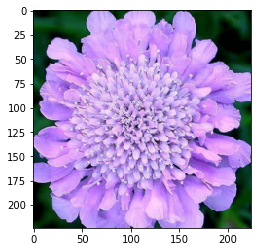

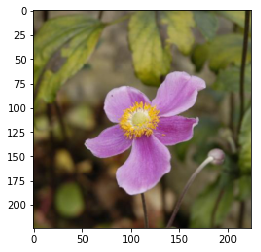

In [11]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
imshow(process_image("flowers/test/22/image_05360.jpg"))
imshow(process_image("flowers/test/62/image_07269.jpg"))



## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [12]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.to(device)
    image = process_image(image_path).to(device)
    
    np_image = image.unsqueeze_(0)
    model.eval()
    with torch.no_grad():
        logps = model.forward(np_image)
    ps = torch.exp(logps)
    top_k,top_classes_idx = ps.topk(topk,dim=1)
    top_k,top_classes_idx = np.array(top_k.to('cpu')[0]), np.array(top_classes_idx.to('cpu')[0])
    
    idx_to_class = {x:y for y,x in model.class_to_idx.items()}
    
    
    top_classes = []
    for index in top_classes_idx:
        top_classes.append(idx_to_class[index])
        
    return list(top_k) , list(top_classes)

predict('flowers/test/3/image_06634.jpg', model)

    

([0.8539027, 0.088918306, 0.01342974, 0.0096967835, 0.0058566486],
 ['94', '84', '95', '4', '96'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

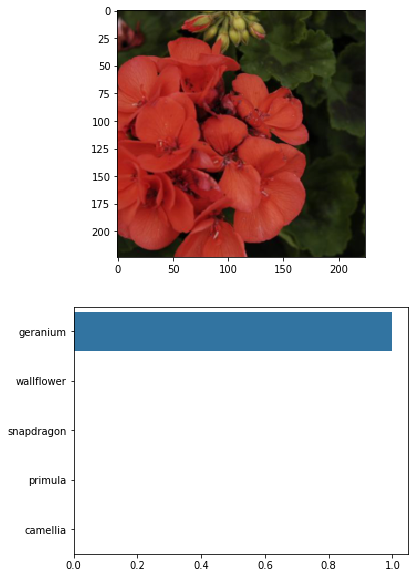

In [13]:
# TODO: Display an image along with the top 5 classes
image_path = "flowers/test/58/image_02663.jpg"
plt.figure(figsize =(6,10))
ax = plt.subplot(2,1,1)
flower_num = image_path.split('/')[2]
title_=cat_to_name[flower_num]
img = process_image(image_path)
imshow(img,ax,title=title_);
probs,classes = predict(image_path,model)
classes_names = [cat_to_name[number] for number in classes]

plt.subplot(2,1,2)
sns.barplot(x=probs, y=classes_names,color=sns.color_palette()[0]);
plt.show()

    

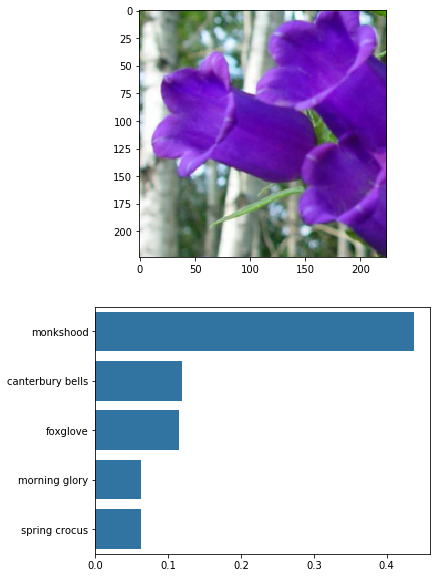

In [14]:
image_path = "flowers/test/3/image_06641.jpg"
plt.figure(figsize =(6,10))
ax = plt.subplot(2,1,1)
flower_num = image_path.split('/')[2]
title_=cat_to_name[flower_num]
img = process_image(image_path)
imshow(img,ax,title=title_);
probs,classes = predict(image_path,model)
classes_names = [cat_to_name[number] for number in classes]

plt.subplot(2,1,2)
sns.barplot(x=probs, y=classes_names,color=sns.color_palette()[0]);
plt.show()
